In [1]:
from corner import corner
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture

from calibration.least_squares import least_squares, ChainStats

In [2]:
RANDOM_SUBSAMPLE = None

Drop 2.73% of data
CPU times: user 1min 43s, sys: 2min 54s, total: 4min 38s
Wall time: 1min 1s


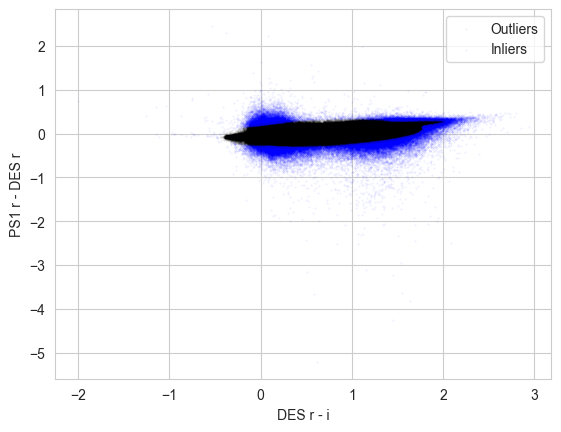

In [3]:
%%time
df = pd.read_csv('ps1_des-ri.csv.bz2', engine='pyarrow')

if RANDOM_SUBSAMPLE is not None:
    df = df.sample(n=RANDOM_SUBSAMPLE, replace=False, random_state=0)

x = np.stack([df["des_mag_r"], df["des_mag_i"], df["ps1_mag_r"]], axis=1)
sigma2 = np.stack([df["des_magerr_r"], df["des_magerr_i"], df["ps1_magerr_r"]], axis=1)**2

del df


r_ps1_des = x[:, 2] - x[:, 0]
ri_des = x[:, 0] - x[:, 1]


def find_outliers(drop_percentile=1.0, *, min_diff=-0.5, max_diff=1.0):
    data = np.stack([r_ps1_des, ri_des], axis=1)

    detector = GaussianMixture(n_components=4, max_iter=100, random_state=0)
    detector.fit(data)
    ln_prob = detector.score_samples(data)
    threshold = np.percentile(ln_prob, drop_percentile)
    outlier_idx = ln_prob < threshold

    plt.scatter(ri_des[~outlier_idx], r_ps1_des[~outlier_idx], color='k', s=0.1, alpha=0.1, label='Outliers')
    plt.scatter(ri_des[outlier_idx], r_ps1_des[outlier_idx], color='b', s=0.1, alpha=0.1, label='Inliers')
    plt.xlabel('DES r - i')
    plt.ylabel('PS1 r - DES r')
    plt.legend()

    outlier_idx |= (r_ps1_des < min_diff) | (r_ps1_des > max_diff)

    return outlier_idx


outlier_idx = find_outliers(1.0, min_diff=-0.1, max_diff=0.3)
print(f'Drop {np.mean(outlier_idx) * 100:.2f}% of data')

In [4]:
%%time
t, y = x[:, :-1], x[:, -1]
A = np.concatenate([t, np.ones((x.shape[0], 1))], axis=1)
sqrt_w = np.sqrt(1 / np.sum(sigma2[:, :-1], axis=1))
(*ord_slopes, ord_intercept), ord_chi2, ord_rank, _ord_s = np.linalg.lstsq(A * sqrt_w[:, None], y * sqrt_w, rcond=None)
ord_slopes_normalized = ord_slopes / np.linalg.norm(np.append(ord_slopes, -1.0))
initial_slopes = np.append(ord_slopes, -1.0)
initial_intercept = ord_intercept
ord_full_dispersion = np.sqrt(ord_chi2 * np.product(ord_slopes_normalized**2) / (x.shape[0] - ord_rank))
ord_observation_dispersion = np.sqrt(np.mean(np.dot(sigma2[:, :-1], ord_slopes_normalized ** 2)))
print(f'{ord_full_dispersion = }', f'{ord_observation_dispersion = }')
initial_dispersion = np.sqrt(ord_full_dispersion ** 2 - ord_observation_dispersion ** 2)
print(f'{initial_slopes = }, {initial_intercept = }, {initial_dispersion = }')

ord_full_dispersion = array([0.86652574]) ord_observation_dispersion = 0.004007410989382465
initial_slopes = array([ 1.13932146, -0.1417076 , -1.        ]), initial_intercept = 0.054119476710963774, initial_dispersion = array([0.86651647])
CPU times: user 436 ms, sys: 352 ms, total: 788 ms
Wall time: 219 ms


In [5]:
%%time

states, ln_probs = least_squares(
    type='ordinal',
    x=x[~outlier_idx],
    sigma2=sigma2[~outlier_idx],
    initial_slopes=[1.139, -0.139, -1.0],
    initial_intercept=0.014,
    initial_dispersion=0.015,
    # slope1 = 1 + alpha
    # slope2 = -alpha
    # slope3 = -1
    ls_params_to_internal=lambda ls_param: jax.numpy.r_[-ls_param[1], ls_param[2], ls_param[3]],
    internal_params_to_ls=lambda internal: jax.numpy.r_[1.0 + internal[0], -internal[0], internal[1], internal[2]],
    # residual_fn=lambda x: jax.numpy.arctan(x),
    # ask dispersion to be not so large
    # ln_prior=lambda internal: HalfNormal(scale=0.001).log_prob(internal[-1]),
    num_samples=30_000,
    num_burnin=1_000,
    # num_samples=100,
    nuts_kwargs=dict(step_size=1e-5, unrolled_leapfrog_steps=3, parallel_iterations=1),
)

2023-03-27 19:38:12.837106: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  reduce-window.7 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-03-27 19:38:14.530788: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2.698693s
Constant folding an instruction is taking > 1s:

  reduce-window.7 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

Thi

CPU times: user 9h 2min 46s, sys: 4min 14s, total: 9h 7min
Wall time: 18h 35min 56s


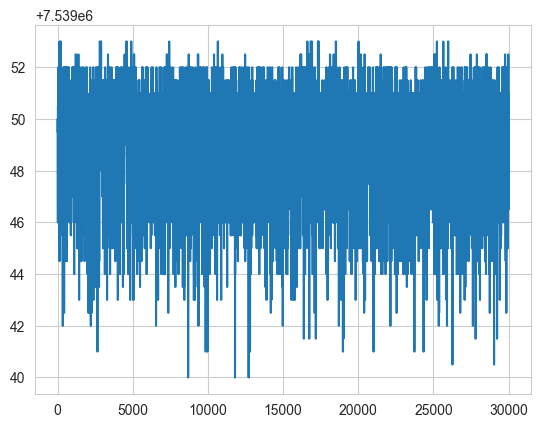

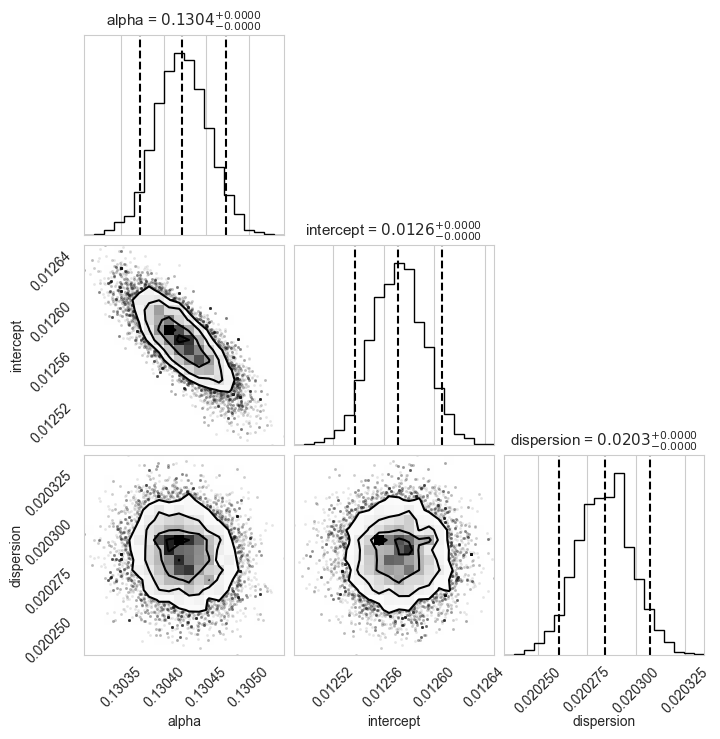

In [6]:
plt.figure()
plt.plot(ln_probs)

corner(
    data=np.asarray(states),
    # labels=['slope_1', 'slope_2', 'intercept', 'dispersion'],
    labels=['alpha', 'intercept', 'dispersion'],
    quantiles=[0.05, 0.5, 0.95],
    show_titles=True,
    title_fmt='.4f',
    title_kwargs={"fontsize": 11},
)

stats = ChainStats.from_states(states)

(array([ 9961.,  9989., 10301., 10615., 11101., 11154., 11494., 11976.,
        12114., 12448., 12812., 13131., 13627., 14082., 14627., 15036.,
        15422., 15857., 16619., 16873., 17693., 18301., 18845., 19706.,
        20222., 21219., 22084., 22968., 23945., 24961., 26143., 27639.,
        28909., 30457., 32128., 33302., 35383., 36985., 38922., 40550.,
        42818., 45089., 46853., 48848., 50882., 52451., 54661., 55705.,
        56966., 58210., 59159., 60323., 61033., 61763., 61786., 62201.,
        61854., 61886., 60829., 60250., 59842., 58825., 57428., 56038.,
        54556., 52719., 50628., 48936., 47006., 45601., 43468., 40736.,
        39048., 37032., 35073., 32863., 30964., 29295., 27368., 25480.,
        24157., 22483., 21440., 19801., 18463., 17496., 16537., 15453.,
        14595., 13546., 12858., 12214., 11500., 11037., 10522.,  9728.,
         9184.,  8841.,  8459.,  7960.]),
 array([-0.04  , -0.0392, -0.0384, -0.0376, -0.0368, -0.036 , -0.0352,
        -0.0344, -0.033

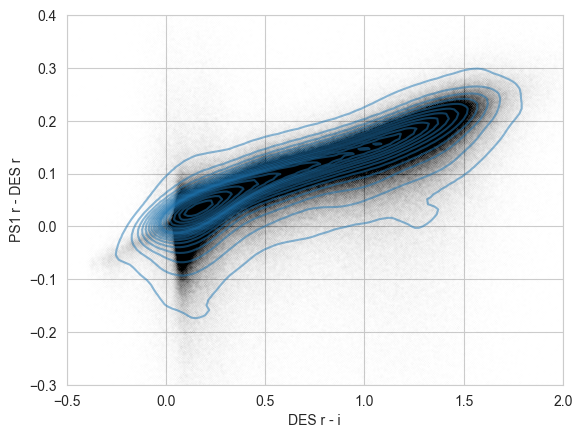

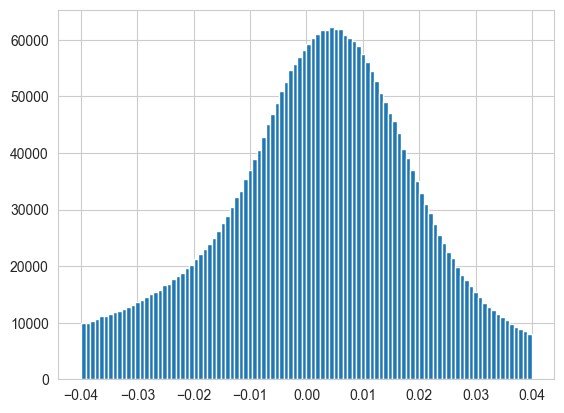

In [7]:
alpha, intercept, dispersion = stats.median

plt.figure()
n_kde = 10_000
idx = np.random.choice(len(ri_des), min(n_kde, len(ri_des)), replace=False)
sns.kdeplot(x=ri_des[idx], y=r_ps1_des[idx], levels=20, alpha=0.5)
plt.scatter(ri_des, r_ps1_des, color='k', s=0.05, alpha=0.01)
plt.xlim(-0.5, 2)
plt.ylim(-0.3, 0.4)
plt.xlabel('DES r - i')
plt.ylabel('PS1 r - DES r')

plt.figure()
plt.hist(r_ps1_des - (alpha * ri_des + intercept), bins=100, range=(-0.04, 0.04))